<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-setup-functions" data-toc-modified-id="Imports-and-setup-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and setup functions</a></span></li><li><span><a href="#Get-data-from-server" data-toc-modified-id="Get-data-from-server-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data from server</a></span></li><li><span><a href="#Read-netCDF-files" data-toc-modified-id="Read-netCDF-files-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read netCDF files</a></span><ul class="toc-item"><li><span><a href="#Methods" data-toc-modified-id="Methods-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Methods</a></span></li><li><span><a href="#Test:-Read-data-from-2021" data-toc-modified-id="Test:-Read-data-from-2021-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Test: Read data from 2021</a></span></li><li><span><a href="#Get-data-from-masked-array" data-toc-modified-id="Get-data-from-masked-array-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Get data from masked array</a></span><ul class="toc-item"><li><span><a href="#Surface-temperature" data-toc-modified-id="Surface-temperature-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Surface temperature</a></span></li></ul></li></ul></li><li><span><a href="#Choose-window-over-geographic-area" data-toc-modified-id="Choose-window-over-geographic-area-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Choose window over geographic area</a></span></li></ul></div>

# Imports and setup functions

In [34]:
import os
from matplotlib import pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray
import ftplib
import re
import getpass

In [4]:
def dataDir(x):
    cwd = os.getcwd()
    
    return cwd + "/data/" + x

# Get data from server

In [1]:
## Create connection to FTP

def access_to_server(USERNAME,PASSWORD, PRODUCT_ID, DATASET_ID):
    # Access to ftp server
    HOSTNAME = ['nrt.cmems-du.eu', 'my.cmems-du.eu']
    try: 
        # NRT server 
        ftp = ftplib.FTP(HOSTNAME[0], USERNAME, PASSWORD)
        ftp.encoding = "utf-8"
        # Move to dataset directory
        ftp.cwd(f'Core/{PRODUCT_ID}/{DATASET_ID}')
    except:
        # MY server
        ftp = ftplib.FTP(HOSTNAME[1], USERNAME, PASSWORD)
        ftp.encoding = "utf-8"
        # Move to dataset directory
        ftp.cwd(f'Core/{PRODUCT_ID}/{DATASET_ID}')
    return ftp 


## Browse and download

def download_ftp_tree(ftp,OUTDIR):
    # Create directory if doesn't exist
    if not os.path.exists(OUTDIR):
        os.makedirs(OUTDIR)
    # Save the initial directory
    original_cwd = ftp.pwd()
    # Show the content of the FTP_address directory
    ftp_content = ftp.nlst()
    for fc in ftp_content:
        try: 
        # check if fc is a directory and create a local subfolder with the same name
            ftp.cwd(f'{fc}')
            print(f'{fc}')
            if not os.path.exists(f'{OUTDIR}/{fc}'):
                os.makedirs(f'{OUTDIR}/{fc}')
                print(f'{OUTDIR}/{fc} is now created')
            download_ftp_tree(ftp,f'{OUTDIR}/{fc}')
            ftp.cwd(original_cwd)
        except: 
        # fc is not a directory but a file, so it's downloaded in its local subfolder
            local_filename = os.path.join(f'{OUTDIR}', fc)
            file = open(local_filename, 'wb')
            ftp.retrbinary('RETR '+ fc, file.write)
            file.close()

In [9]:
HOST = "my.cmems-du.eu"

USERNAME = "lvilallonga"
PASSWORD = "dumbPW0123"

PRODUCT_ID = "IBI_ANALYSISFORECAST_PHY_005_001" #"GLOBAL_ANALYSISFORECAST_PHY_001_024"
DATASET_ID = "cmems_mod_ibi_phy_anfc_0.027deg-3D_P1D-m" #"cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m"
OUT_DIR = dataDir("testDump")

In [10]:
FTP = access_to_server(USERNAME, PASSWORD, PRODUCT_ID, DATASET_ID)
    
# Download the content of the dataset
download_ftp_tree(FTP, OUT_DIR)
print('Download complete!')
    
# Closure 
FTP.close()

2020
/home/lucia/projects/FORMES/rainfall-pde-ml/data/testDump/2020 is now created
11
/home/lucia/projects/FORMES/rainfall-pde-ml/data/testDump/2020/11 is now created
12
/home/lucia/projects/FORMES/rainfall-pde-ml/data/testDump/2020/12 is now created
2021
/home/lucia/projects/FORMES/rainfall-pde-ml/data/testDump/2021 is now created
01
/home/lucia/projects/FORMES/rainfall-pde-ml/data/testDump/2021/01 is now created
02
/home/lucia/projects/FORMES/rainfall-pde-ml/data/testDump/2021/02 is now created
03
/home/lucia/projects/FORMES/rainfall-pde-ml/data/testDump/2021/03 is now created
04
/home/lucia/projects/FORMES/rainfall-pde-ml/data/testDump/2021/04 is now created
05
/home/lucia/projects/FORMES/rainfall-pde-ml/data/testDump/2021/05 is now created
06
/home/lucia/projects/FORMES/rainfall-pde-ml/data/testDump/2021/06 is now created
07
/home/lucia/projects/FORMES/rainfall-pde-ml/data/testDump/2021/07 is now created
08
/home/lucia/projects/FORMES/rainfall-pde-ml/data/testDump/2021/08 is now cr

IsADirectoryError: [Errno 21] Is a directory: '/home/lucia/projects/FORMES/rainfall-pde-ml/data/testDump/2021'

# Read netCDF files

## Methods

In [3]:
def create_month_dataset(year_path, exclude=[]):
    
    # |data/
    # |--- |SST_ATL_PHY.../
    # |----|-------------- |2021/
    # |----|---------------|--- |01/
    # |----|---------------|----|- 20210101_image.nc  # (day 1)
    # |----|---------------|----|- 20210102_image.nc  # (day 2)
    # |----|---------------|----|- 20210103_image.nc  # (day 3) ...
    
    dataset = {}
    
    m_paths = [year_path + m for m in os.listdir(year_path)]
    m_paths.sort()
    
    print("Creating dataset from year: " + year_path[-5:-1] + "...")
    
    for m in m_paths:
        
        # Create ID
        m_id = "sst_" + year_path[-5:-1] + "-" + m[-2:]
        
        # Read data into MFDataset
        print("...Month: " + m[-2:] + "...")
        
        m_nc = nc.MFDataset(files=(m + "/*.nc"), aggdim="time", 
                            exclude=exclude)
       
        # Save to dictionary with datasets
        dataset[m_id] = m_nc
        
    return dataset

In [20]:
def create_month_dataset_xa(year_path, include="all", aggdim="time"):
    dataset = {}
    
    m_paths = [year_path + m for m in os.listdir(year_path)]
    m_paths.sort()
    
    print("Creating dataset from year: " + year_path[-5:-1] + "...")
    
    for m in m_paths:
        print(m)
        
        # Create ID
        m_id = "sst_" + year_path[-5:-1] + "-" + m[-2:]
        
        # Read data into xarrayDataset
        print("...Month: " + m[-2:] + "...")
        
        m_xa = xarray.open_mfdataset(paths=(m + "/*.nc"), concat_dim="time",
                                     combine="nested"
                                     data_vars=include)
    
        # Save to dictionary with datasets
        dataset[m_id] = m_xa
        
    return dataset

In [36]:
test_xa = create_month_dataset_xa(dataDir("testDump/2021/"), include="thetao")

Creating dataset from year: 2021...
/home/lucia/projects/FORMES/rainfall-pde-ml/data/testDump/2021/05
...Month: 05...


ValueError: unrecognized chunk manager dask - must be one of: []

## Test: Read data from 2021

In [4]:
depth = nc.Dataset(dataDir("GLOBAL_ANALYSISFORECAST_PHY_001_024/2021/01/glo12_rg_1d-m_20210101-20210101_3D-thetao_hcst_R20210113.nc"))
depth["depth"]

<class 'netCDF4._netCDF4.Variable'>
float32 depth(depth)
    valid_min: 0.494025
    valid_max: 5727.917
    units: m
    positive: down
    unit_long: Meters
    long_name: Depth
    standard_name: depth
    axis: Z
unlimited dimensions: 
current shape = (50,)
filling off

In [4]:
vars_to_exclude = ["longitude", "latitude", "depth", "time"] 

test = create_month_dataset(dataDir("GLOBAL_ANALYSISFORECAST_PHY_001_024/2021/"),
                            vars_to_exclude)

Creating dataset from year: 2021...
...Month: 01...
...Month: 02...


In [5]:
# Load January data
# First dimension (here, 2) will be 28-30 (days in each month)

test["sst_2021-01"]["thetao"].shape 

(2, 50, 2041, 4320)

In [6]:
test["sst_2021-01"]

<class 'netCDF4._netCDF4.MFDataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    producer: CMEMS - Global Monitoring and Forecasting Centre
    title: daily mean fields from Global Ocean Physics Analysis and Forecast updated Daily
    area: Global
    Conventions: CF-1.8
    credit: E.U. Copernicus Marine Service Information (CMEMS)
    contact: https://marine.copernicus.eu/contact
    references: http://marine.copernicus.eu
    source: MOI GLO12
    licence: http://marine.copernicus.eu/services-portfolio/service-commitments-and-licence/
    institution: Mercator Ocean International
    dimensions = ('longitude', 'latitude', 'depth', 'time')
    variables = ('longitude', 'latitude', 'depth', 'time', 'thetao')
    groups = ()

## Get data from masked array 

### Surface temperature

In [5]:
def get_surface_temp(data):
    """Method to extract the first level of depth for which there is data.
        
       Parameters
       ----------
       data : numpy.ndarray or numpy.ma.core.MaskedArray
    
    """
    data_c = data.copy
    
    return data_c["thetao"][:, 0, :, :]

In [7]:
# test_surface = get_surface_temp(test["sst_2021-01"]["thetao"][0])
test["sst_2021-01"]["thetao"][0].shape

(50, 2041, 4320)

In [8]:
test_surface = test["sst_2021-01"]["thetao"][0][0, :, :]

In [9]:
test_surface.shape

(2041, 4320)

In [37]:
test_surface

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [-1.6020889282226562, -1.6020846366882324, -1.6020804643630981,
          ..., -1.6021026372909546, -1.6020978689193726,
          -1.60209321975708],
         [-1.601487636566162, -1.6014870405197144, -1.6014862060546875,
          ..., -1.601489782333374, -1.6014890670776367,
          -1.6014882326126099],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [-1.6041874885559082, -1.6041854619979858, -1.6041836738586426,
          ..., -1.6041934490203857, -1.6041914224624634,
          -1.6041895151138306],
         [-1.606079339981079, -1.6060655117034912, -1.6060515642166138,
          ..., -1.6061214208602905, -1.6061073541641235,
          -1.606093406677246],
         [--, --, --, ..., --, --,

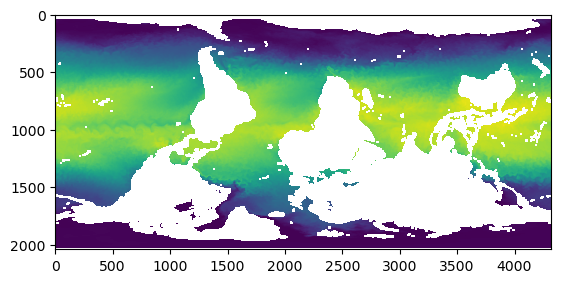

In [7]:
plt.imshow(test_surface)

In [10]:
print(type(test_surface))

# Computations on masked arrays don't use the masked (invalid) values
print(test_surface.mean())  
print(test_surface.data.mean())

<class 'numpy.ma.core.MaskedArray'>
13.893350223476016
inf


/home/lucia/anaconda3/envs/ml-pde/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [ ]:
# TODOs:
# 0. Switch to processing daily files at a time
# 1. Choose & slice geographic area
# 2. Pickle dump?
# 3. Flip lat/lon for plotting
# 4. Load extracted numeric values into PyTorch Dataset
#    Link: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
# 5. Clean up imports
# 6. Create a cute image showing the regions we're using, similar to paper

# Choose window over geographic area

In [11]:
# TODO: write another method to slice into 256x256 images
def select_geo_area(img, latmin, latmax, lonmin, lonmax, var="thetao"):
    
    lat, lon = img.variables["latitude"][:], img.variables["longitude"][:]
    v = img.variables[var][:]
    
    lat_mask = np.where((lat < latmax) & (lat > latmin), True, False)
    lon_mask = np.where((lon < lonmax) & (lon > lonmin), True, False)
    
    var_slice = []
    
    for m in range(len(v)):
        var_slice.append(v[m,][lat_mask,:][:,lon_mask])

    return np.ma.masked_array(var_slice)

In [ ]:
test_area = select_geo_area(test["sst_2021-01"], latmin=-20, latmax=3, lonmin=-6, lonmax=20)

In [8]:
#test_slices2 = slice_images_by_geo(test["sst_2021-06"], latmin=45, latmax=50.5, lonmin=-20.5, lonmax=-15)
#print(test_slices2.shape)

(30, 275, 275)


In [9]:
#print(test_slices2.min())
#print(test_slices2.max())
#print(test_slices2.mean())

282.75
291.44
287.7358675376873


In [10]:
#test_slices2[:,][:256,:256].shape #[:,:256].shape # 30x256x256

(30, 256, 275)

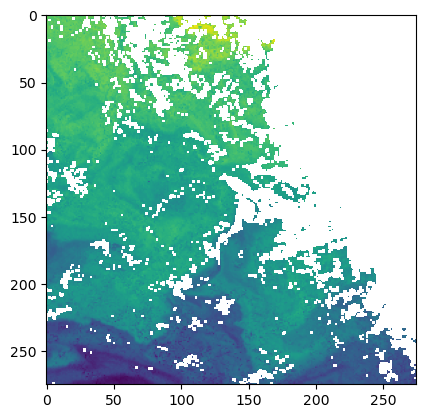

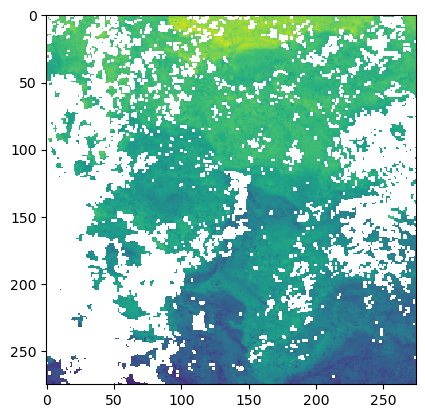

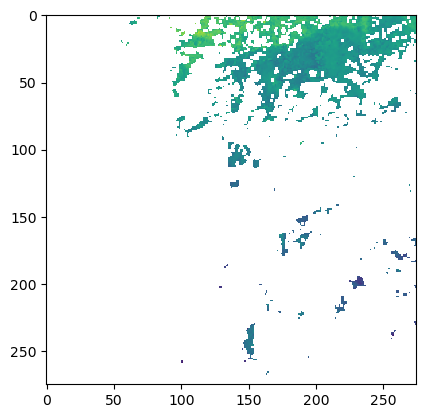

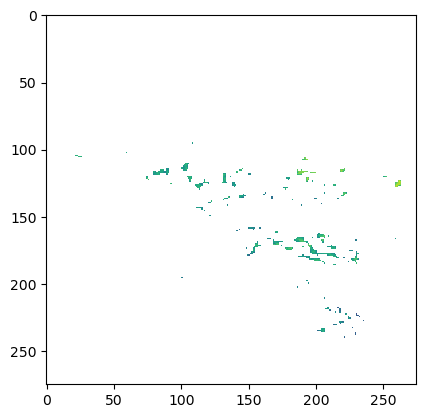

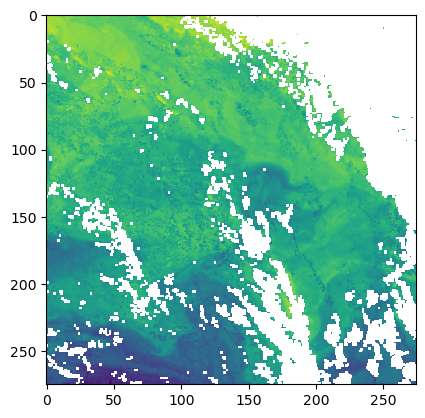

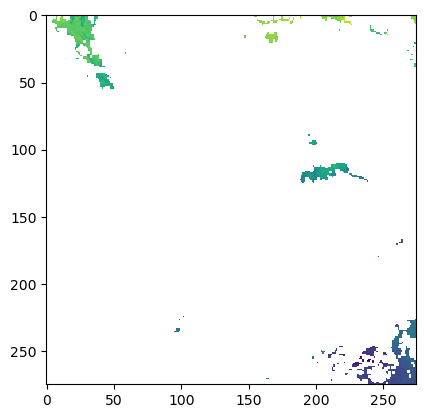

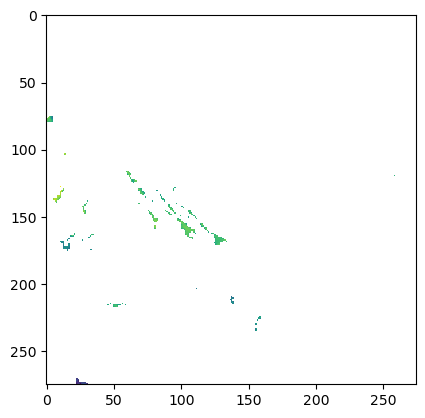

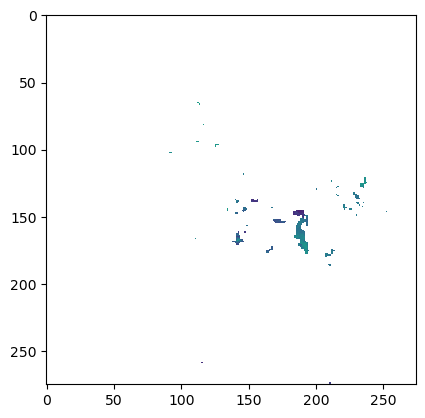

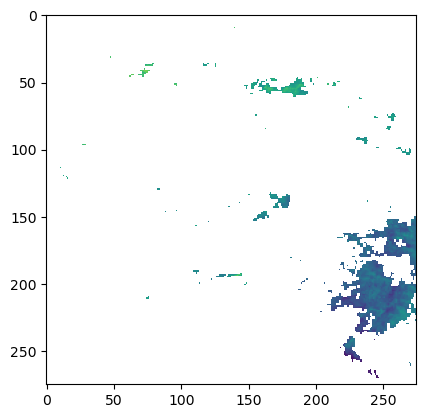

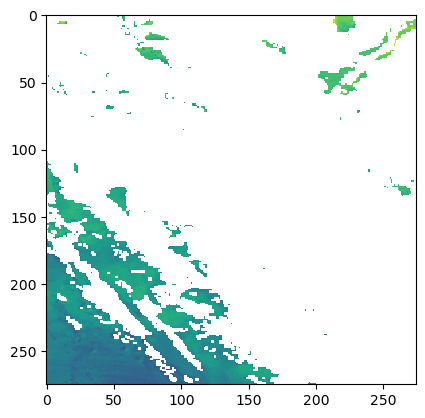

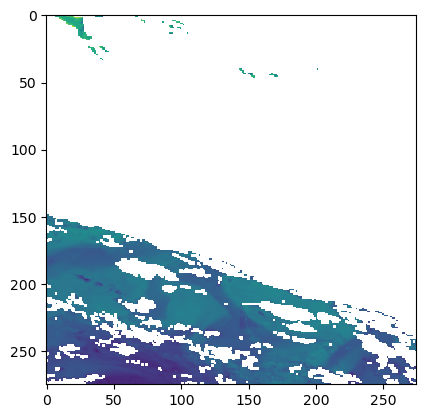

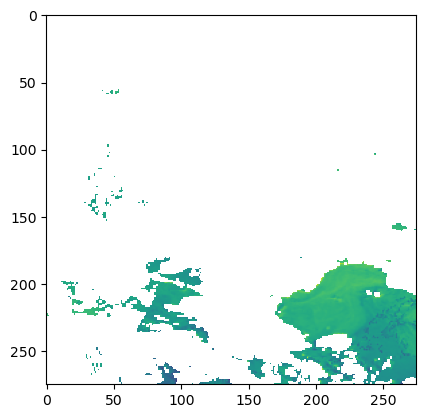

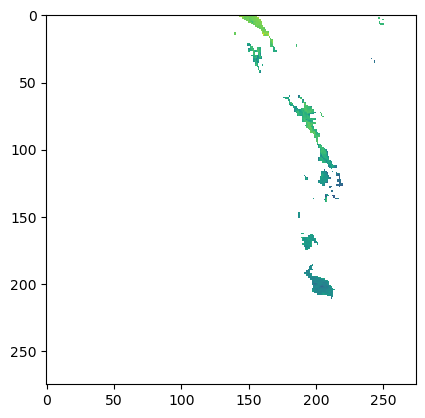

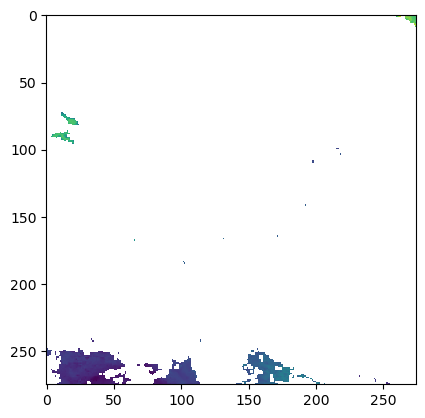

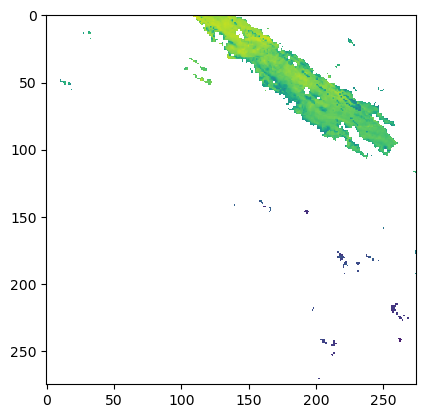

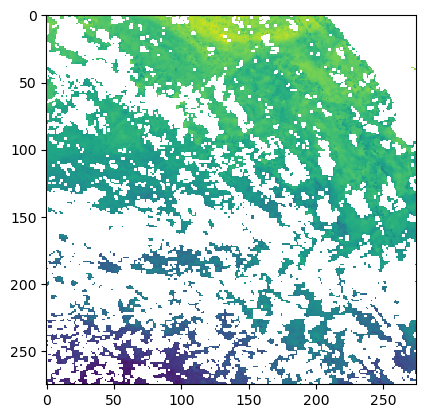

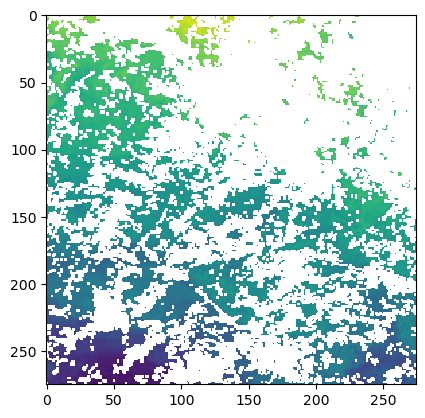

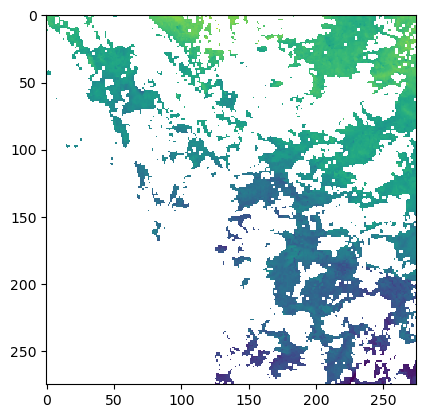

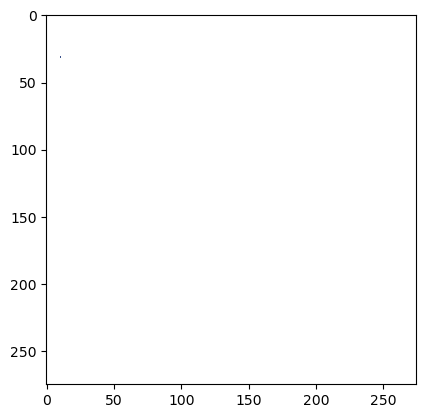

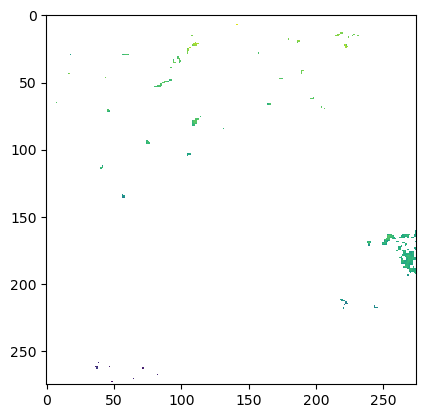

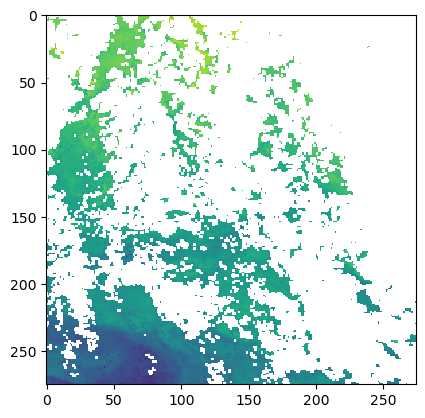

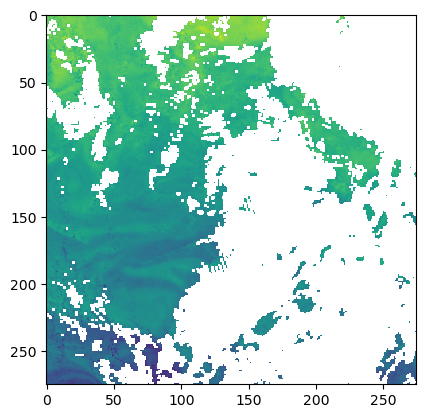

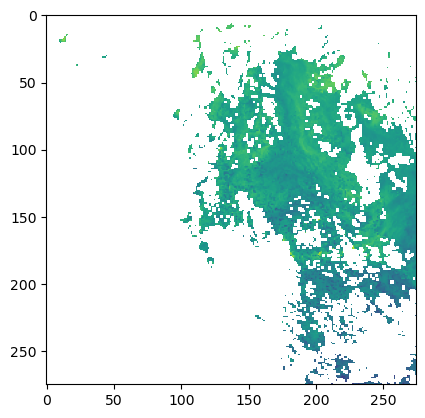

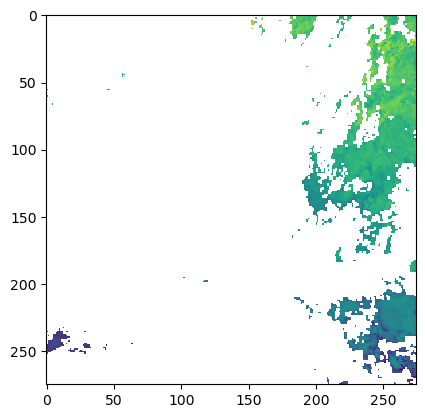

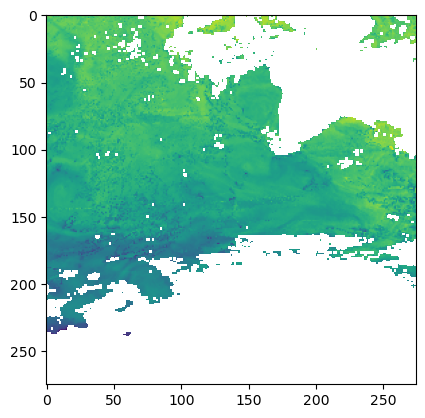

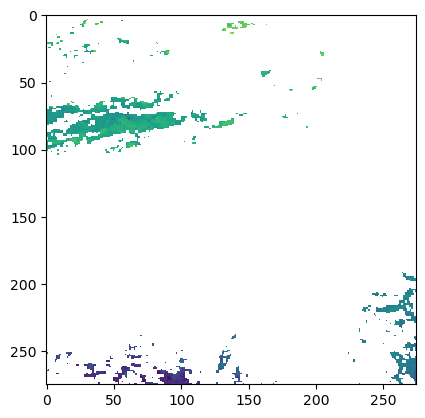

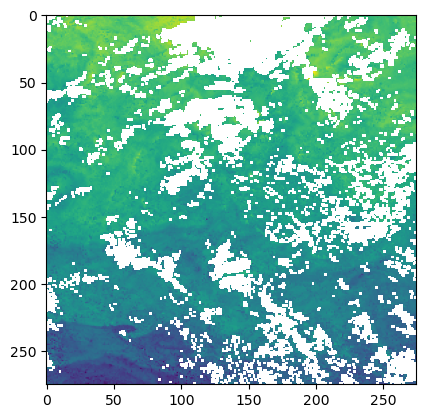

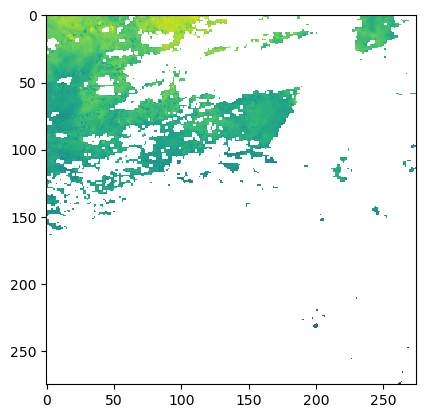

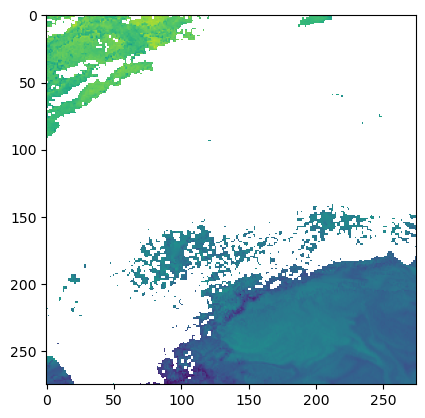

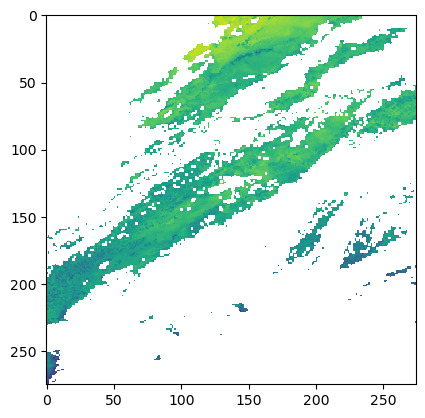

In [11]:
#june1 = sst[0,] # the snapshot of the first of June 
#plt.imshow(june1)

for i in range(len(test_slices2)):
    plt.imshow(test_slices2[i,])
    plt.show()

https://www.youtube.com/@climateunboxed/videos

https://www.earthinversion.com/utilities/reading-NetCDF4-data-in-python/

https://stackoverflow.com/questions/36360469/read-nc-netcdf-files-using-python

https://unidata.github.io/netcdf4-python/#creatingopeningclosing-a-netcdf-file

https://marine.copernicus.eu/user-corner/user-notification-service/gh-416-technical-issue-impacting-new

https://www.earthdatascience.org/courses/use-data-open-source-python/hierarchical-data-formats-hdf/use-netcdf-in-python-xarray/

https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html

https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

https://github.com/emited/flow/blob/master/flow/modules/estimators.py#L64

https://github.com/emited/flow/blob/master/flow/datasets/nc.py

https://stackoverflow.com/questions/2051744/how-to-invert-the-x-or-y-axis

https://help.marine.copernicus.eu/en/articles/6444313-how-to-fetch-marine-data-from-copernicus-marine-ftp-server-in-python

Data sources:
1. https://data.marine.copernicus.eu/product/GLOBAL_ANALYSISFORECAST_PHY_001_024/description
2. https://help.marine.copernicus.eu/en/articles/4521873-how-to-download-a-dataset-from-ftp-server
4. https://catalogue.marine.copernicus.eu/documents/PUM/CMEMS-GLO-PUM-001-024.pdf